In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from numpy import pi, sqrt

np.set_printoptions(suppress=True)

def measure(state, size=1):
    """For a given state returns a measurement (or \'size\' measurements, if specified) of the state in
    the computational basis along with its wavefunction (probabilities of each outcome)"""
    n = state.shape[0]
    probs = np.abs(state.dag().full())**2
    probs = probs.reshape(n)
    if size>1:
        draw = np.random.choice(n,p=probs,size=size)
    else:
        draw = np.random.choice(n,p=probs)
    return(draw,list(probs))

In [2]:
R1 = tensor(basis(2,0),basis(2,0))
R2 = tensor(basis(2,0),basis(2,0))
R = tensor(R1,R2)

n = 4
nb_agnts = 1000
sgm = pi/10

Aux = basis(2,0)
Auxs = [Aux]
for i in range(n+1):
    Aux = tensor(basis(2,0),Aux)
    Auxs += [Aux]
    
eye = qeye(2)
eyes = [eye]
for i in range(n+6):
    eye = tensor(qeye(2),eye)
    eyes += [eye]

def err(sigma):
    return(random.gauss(0, sigma))

X = Qobj([[0,1],[1,0]])
def MS(chi, sgm):
    prm = chi + err(sgm)
    return(np.cos(prm)*tensor(qeye(2),qeye(2)) -1j * np.sin(prm)*tensor(X,X))

def D0(sgm):
    return(tensor(ry(pi/2+err(sgm)),qeye(2))*tensor(qeye(2),ry(pi/2+err(sgm)))*MS(pi/4,sgm)*tensor(rx(-pi/2+err(sgm)),qeye(2))*tensor(qeye(2),rx(-pi/2+err(sgm)))*tensor(ry(-pi/2+err(sgm)),qeye(2))*tensor(qeye(2),ry(-pi/2+err(sgm))))

def H(sgm):
    return(rx(-pi/2+err(sgm))*rz(-pi/2+err(sgm))*rx(-pi/2+err(sgm)))

def gen_Hs(nb,sgm):
    Hs = H(sgm)
    for i in range(nb):
        Hs = tensor(Hs,H(sgm))
    return(Hs)

def gen_Us(p1,p2,lmbd,prv1,prv2,prv3,sgm):
    Ut3 = controlled_gate(ry(pi/2 + err(sgm)))
    Ut1 = tensor(ry(2*math.acos(sqrt(p1+p2)) + err(sgm)),qeye(2))
    Ut2 = controlled_gate(ry(2*math.acos(sqrt(p1/(p1+p2))) + err(sgm)), control_value=0)
    Ut2b = controlled_gate(ry(2*math.acos(sqrt((p1+lmbd)/(p1+p2))) + err(sgm)), control_value=0)
    
    Urt3 = controlled_gate(ry(pi/2 + err(sgm)))
    Urt1 = tensor(ry(2*math.acos(sqrt(prv1[0]+prv1[1])) + err(sgm)),qeye(2))
    Urt1b = tensor(ry(2*math.acos(sqrt(prv2[0]+prv2[1])) + err(sgm)),qeye(2))
    Urt1c = tensor(ry(2*math.acos(sqrt(prv3[0]+prv3[1])) + err(sgm)),qeye(2))
    Urt2 = controlled_gate(ry(2*math.acos(sqrt(prv1[0]/(prv1[0]+prv1[1]))) + err(sgm)), control_value=0)
    Urt2b = controlled_gate(ry(2*math.acos(sqrt(prv2[0]/(prv2[0]+prv2[1]))) + err(sgm)), control_value=0)
    Urt2c = controlled_gate(ry(2*math.acos(sqrt(prv3[0]/(prv3[0]+prv3[1]))) + err(sgm)), control_value=0)
    return(Ut3*Ut2b*Ut1,Ut3*Ut2*Ut1,Urt3*Urt2*Urt1,Urt3*Urt2b*Urt1b,Urt3*Urt2c*Urt1c)

def gen_W(p1,p2,lmbd,prv1,prv2,prv3,sgm):
    U1,U2,Ur1,Ur2,Ur3 = gen_Us(p1,p2,lmbd,prv1,prv2,prv3,sgm)
    U1tempc00 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 0)),U1*U2.dag()-eyes[1])+eyes[3]
    Ur1c00 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 0)),Ur1*Ur3.dag()-eyes[1])+eyes[3]
    Ur2c01 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 1)),Ur2*Ur3.dag()-eyes[1])+eyes[3]
    Up = U1tempc00*tensor(eyes[1],U2)
    Vp_temp = Ur1c00*Ur2c01*tensor(eyes[1],Ur3)
    Vp = swap(N=4, targets=[0, 2])*swap(N=4, targets=[1, 3])*Vp_temp*swap(N=4, targets=[0, 2])*swap(N=4, targets=[1, 3])
    refA = Up*tensor(eyes[1],D0(sgm))*Up.dag()
    refB = Vp*tensor(D0(sgm),eyes[1])*Vp.dag()
    return(refB*refA,Up)
    
def gen_Ws(p1,p2,lmbd,prv1,prv2,prv3,sgm,kk):
    W,_ = gen_W(p1,p2,lmbd,prv1,prv2,prv3,sgm)
    Ws = [tensor(fock_dm(2,1),W-eyes[3])+eyes[4]]
    for i in range(1,kk):
        W,_ = gen_W(p1,p2,lmbd,prv1,prv2,prv3,sgm)
        Ws += [tensor(fock_dm(2,1),tensor(eyes[i-1],W**(2**i))-eyes[i+3])+eyes[i+4]]
    W,_ = gen_W(p1,p2,lmbd,prv1,prv2,prv3,sgm)
    Ws+=[tensor(fock_dm(2,1),tensor(eyes[kk-1],W**(2**kk))-eyes[kk+3])+eyes[kk+4]]
    return(Ws)

def gen_Wcs(Ws, c, kk):
    tmp = random.randint(0, c)
    binary = [int(x) for x in bin(tmp)[2:]][::-1]
    binary = binary + [0]*(kk+1-len(binary))
    Wcs=[]
    for i, b in enumerate(binary[:-1]):
        if b:
            Wcs += [tensor(eyes[kk-i-1],Ws[i])]
        else:
            Wcs += [False]
    if binary[-1]:
        Wcs += [Ws[-1]]
    return(Wcs, tmp*4)

NUss = []
deltas = []
old_perc = 0
for c in range(2,2**n):
    k = math.log2(c)
    lmbd = 1 - 2**(-2*k)
    deltas += [1-lmbd]
    p2 = lmbd
    p1 = (1-lmbd)/4
    p3 = 1-p1-p2
    distrib = [p1,p2,p3/2,p3/2]
    
    Pb = np.array([distrib]*4).transpose()
    Pb[0][0] += lmbd
    Pb[1][0] -= lmbd
    stat_distrib = [p1/(1-lmbd),p2-p1*lmbd/(1-lmbd),p3/2,p3/2]
    Pb_rvrs = Pb*np.array(stat_distrib)
    Pb_rvrs = Pb_rvrs.transpose()/np.array(stat_distrib)

    prv1 = Pb_rvrs[:,0]
    prv2 = Pb_rvrs[:,1]
    prv3 = Pb_rvrs[:,2]
    
    kk = math.ceil(k)
    # nb ancilla = kk+1, position kk in lists

    nullaux = Auxs[kk]
    D0aux = 2*nullaux*nullaux.dag()-eyes[kk]
    stat_1 = sqrt(p1/(1-lmbd))*tensor(basis(2,0),basis(2,0))+sqrt(p2-p1*lmbd/(1-lmbd))*tensor(basis(2,0),basis(2,1))+sqrt(p3/2)*tensor(basis(2,1),basis(2,0))+sqrt(p3/2)*tensor(basis(2,1),basis(2,1))
    Up = gen_W(p1,p2,lmbd,prv1,prv2,prv3,sgm)[1]
    stat = Up*tensor(stat_1,R2)
    refAct = tensor(eyes[kk],tensor(D0(sgm),eyes[1]))
    Memb = tensor(Auxs[kk], stat)
    
    NUs = []
    for a in range(nb_agnts):
        Ws = gen_Ws(p1,p2,lmbd,prv1,prv2,prv3,sgm,kk)
        NU = 0
        fnd = False
        while not fnd:
            Wcs, nb_calls = gen_Wcs(Ws, c, kk)
            NU += nb_calls

            PD = tensor(gen_Hs(kk,sgm),eyes[3])
            for Wc in Wcs:
                if Wc!=False:
                    PD = Wc*PD
            PD = tensor(gen_Hs(kk,sgm),eyes[3])*PD
            ARO = PD.dag()*tensor(D0aux,eyes[3])*PD

            res = np.array(measure(ARO*refAct*Memb)[1])
            res = res.reshape(int(len(res)/16),16)
            res = np.sum(res, axis = 0).reshape(4,4)
            res = np.sum(res, axis = 0)
            mes = measure(Qobj(np.sqrt(res)))[0]
            if mes == 0:
                fnd = True
        NUs+=[NU]
    NUss+=[NUs]
    perc = 100*c/2**n
    if perc >= old_perc+5:
        old_perc = 20*int(perc/20)
        print(int(perc),"%")
print("done")

12 %
18 %
25 %
31 %
37 %
43 %
50 %
56 %
62 %
68 %
75 %
81 %
87 %
93 %
done


In [3]:
import pickle
f = open('simulation_delta_error-pi-10.save', 'wb')
pickle.dump([deltas, NUss], f)
f.close()

In [2]:
import pickle
file = open('simulation_delta_error-pi-10.save', 'rb')
[deltas, NUss] = pickle.load(file)
file.close()

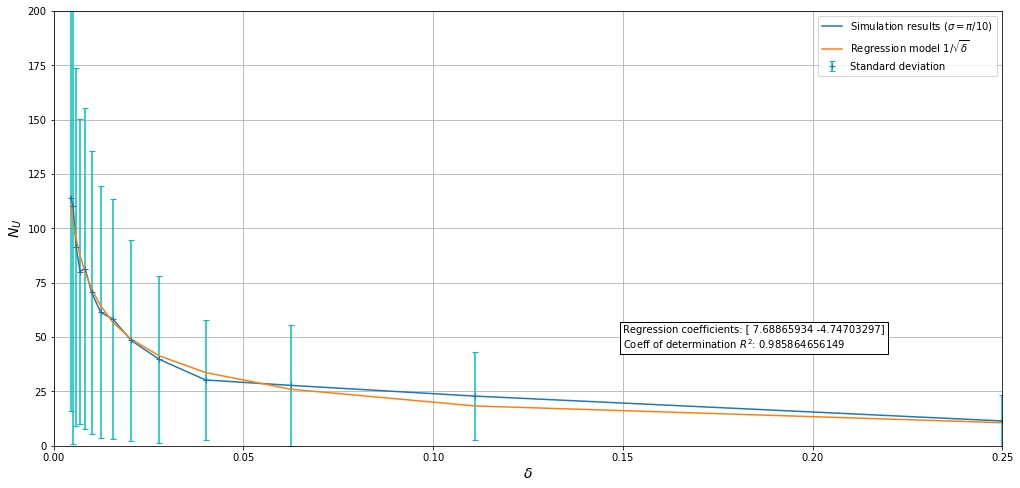

Curve fitting coefficients :  [ 7.68865934 -4.74703297]
Coefficient of determination R^2 :  0.985864656149


In [3]:
NUss_mean = []
NUss_std = []
for NUs in NUss:
    NUss_mean+=[np.mean(NUs)]
    NUss_std+=[np.std(NUs)]

curve_fit = np.polyfit(1/np.sqrt(deltas), NUss_mean, 1, full=True)
coeff = curve_fit[0]
res = curve_fit[1][0]
rsqr = 1 - res / (len(NUss_mean) * np.var(NUss_mean))

plt.figure(figsize=(17,8))
results, = plt.plot(deltas, NUss_mean, label='Simulation results ($\sigma=\pi/10$)')
model, = plt.plot(deltas, coeff[0]/np.sqrt(deltas)+coeff[1], label='Regression model $1/\sqrt{\delta}$')
errbar = plt.errorbar(deltas, NUss_mean, NUss_std, ecolor='c', linestyle='None', marker='+', capsize=3, label='Standard deviation')
axes = plt.gca()
axes.set_ylim([0,200])
axes.set_xlim([0,0.25])

plt.legend(handles=[results, model, errbar])
plt.text(0.15,45,'Regression coefficients: '+str(coeff)+'\nCoeff of determination $R^2$: '+str(rsqr),bbox=dict(facecolor='white',edgecolor='black',boxstyle='square'))

plt.xlabel('$\delta$', fontsize=14)
plt.ylabel('$N_U$', fontsize=14)
plt.grid(True)
plt.show()
print("Curve fitting coefficients : ", coeff)
print('Coefficient of determination R^2 : ', rsqr)